In [16]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("white")
sns.set(context='notebook',
        style='ticks',
        font_scale=1,
        rc={'axes.grid':True,
            'grid.color':'.9',
            'grid.linewidth':0.75})
from joblib import Parallel, delayed
import scipy.optimize as optimize
from scipy.optimize import minimize_scalar, brute
from tqdm import tqdm
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
import scipy.io as sio
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import wandb

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import sys
import os
sys.path.insert(0, os.path.dirname(os.getcwd()))

In [3]:
def generate_in_distribution_data(n, mu, sigma, pi_in):
    n_1 = round(n*pi_in)
    n_0 = round(n*(1-pi_in))
    mu_1 = mu
    mu_0 = -mu_1
    X_0 = np.random.normal(mu_0, sigma, n_0)
    X_1 = np.random.normal(mu_1, sigma, n_1)
    X = np.concatenate((X_0, X_1))
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

def generate_out_distribution_data(n, mu, sigma, pi_out, delta):
    n_1 = round(n*pi_out)
    n_0 = round(n*(1-pi_out))
    mu_1 = mu + delta
    mu_0 = -mu + delta
    X_0 = np.random.normal(mu_0, sigma, n_0)
    X_1 = np.random.normal(mu_1, sigma, n_1)
    X = np.concatenate((X_0, X_1))
    Y = np.concatenate((np.zeros(n_0), np.ones(n_1)))
    return X, Y

def get_data(n, m, mu, sigma, delta, pi_in=0.5, pi_out=0.5):
    np.random.seed(10)
    X, Y = generate_in_distribution_data(n, mu, sigma, pi_in)
    np.random.seed(10)
    X_o, Y_o = generate_out_distribution_data(m, mu, sigma, pi_out, delta)

    df = pd.DataFrame()
    df['data'] = np.concatenate((X[Y==0], X[Y==1], X_o[Y_o==0], X_o[Y_o==1]))
    df['class'] = np.concatenate((Y[Y==0], Y[Y==1], Y_o[Y_o==0], Y_o[Y_o==1]))
    tasks = ["t1" for x in range(len(Y))]
    tasks.extend(["t2" for x in range(len(Y_o))])
    df['task'] = tasks
    df.task = df.task.astype("category")
    return df

def expected_risk(n, m, mu, sigma, delta):
    mu_h = (m/(n+m))*delta
    sigma_h = sigma*np.sqrt(1/(n+m))
    risk = 0.5*(1 + norm.cdf((mu_h - mu)/(np.sqrt(sigma**2 + sigma_h**2))) - norm.cdf((mu_h + mu)/(np.sqrt(sigma**2 + sigma_h**2))))
    return risk


In [63]:
results = []

In [64]:
n_list = np.array([50, 100, 200, 500, 700, 1000])
m_list = np.arange(0, 1000, 25)
delta = 1.6
mu = 5
sigma = 10

risk = np.zeros((len(n_list), len(m_list)))
for i, n in enumerate(n_list):
    for j, m in enumerate(m_list):
        risk[i, j] = expected_risk(n, m, mu, sigma, delta)

X, Y = np.meshgrid(n_list/2, m_list/2)
results.append((X, Y, risk))

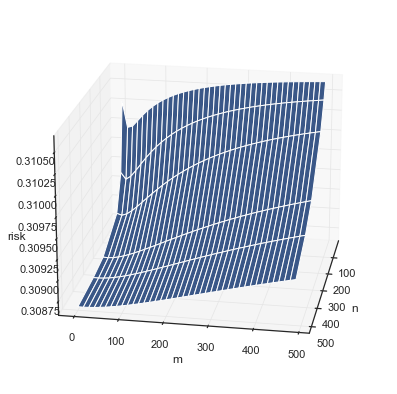

In [65]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, risk.T)
ax.set_xlabel("n")
ax.set_ylabel("m")
ax.set_zlabel("risk")
ax.view_init(20, 10)
plt.show()

In [66]:
import os
os.environ['WANDB_DIR'] = '/Users/ashwindesilva/wandb'
os.environ['WANDB_CACHE_DIR'] = '/Users/ashwindesilva/wandb'
os.environ['WANDB_CONFIG_DIR'] = '/Users/ashwindesilva/wandb'

In [67]:
api = wandb.Api()
runs = api.runs("ashwin1996/ood-tl-extra")
tag = ["1-effect-of-target-sample-size/mnist"]

# summary_list, config_list, name_list = [], [], []
n = []
m = []
avg_error = []
std_error = []
for run in runs: 
    run_tag = run.config['tag'] 
    if run_tag in tag:
        n.append(run.config['task']['n'])
        m.append(run.config['task']['m_n'])
        avg_error.append(run.summary['avg_err'])
        std_error.append(run.summary['std_err'])

runs_df = pd.DataFrame({
    "n": n,
    "m": m,
    "avg_error": avg_error,
    "std_error": std_error
    })

runs_df = runs_df.sort_values(by=['n', 'm']).reset_index(drop=True)

In [68]:
n_list = np.unique(runs_df['n'].to_numpy())
m_list = np.unique(runs_df['m'].to_numpy())[:-3]
X, Y = np.meshgrid(n_list, m_list)

risk = np.zeros((len(n_list), len(m_list)))
for i, n in enumerate(n_list):
    for j, m in enumerate(m_list):
        A = runs_df[runs_df['n']==n]
        risk[i, j] = A[A['m'] == m]['avg_error'].to_numpy()

results.append((X, Y, risk))

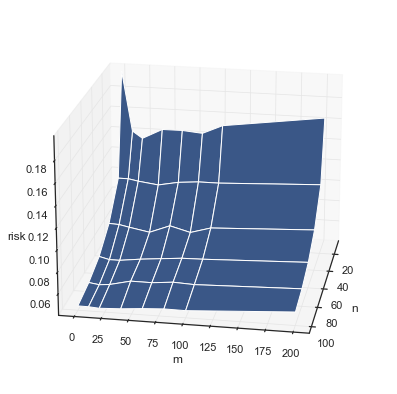

In [69]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, risk.T)
ax.set_xlabel("n")
ax.set_ylabel("m")
ax.set_zlabel("risk")
ax.view_init(20, 10)
plt.show()

In [70]:
api = wandb.Api()
runs = api.runs("ashwin1996/ood-tl-extra")
tag = ["1-effect-of-target-sample-size/domainnet"]

# summary_list, config_list, name_list = [], [], []
n = []
m = []
avg_error = []
std_error = []
for run in runs: 
    run_tag = run.config['tag'] 
    if run_tag in tag:
        n.append(run.config['task']['n'])
        m.append(run.config['task']['m_n'])
        avg_error.append(run.summary['avg_err'])
        std_error.append(run.summary['std_err'])

runs_df = pd.DataFrame({
    "n": n,
    "m": m,
    "avg_error": avg_error,
    "std_error": std_error
    })

runs_df = runs_df.sort_values(by=['n', 'm']).reset_index(drop=True)

In [71]:
n_list = np.unique(runs_df['n'].to_numpy())
m_list = np.unique(runs_df['m'].to_numpy())[:-2]
X, Y = np.meshgrid(n_list, m_list)

risk = np.zeros((len(n_list), len(m_list)))
for i, n in enumerate(n_list):
    for j, m in enumerate(m_list):
        A = runs_df[runs_df['n']==n]
        risk[i, j] = A[A['m'] == m]['avg_error'].to_numpy()

results.append((X, Y, risk))

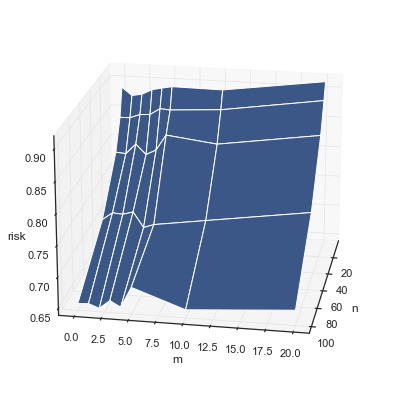

In [72]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, risk.T)
ax.set_xlabel("n")
ax.set_ylabel("m")
ax.set_zlabel("risk")
ax.view_init(20, 10)
plt.show()

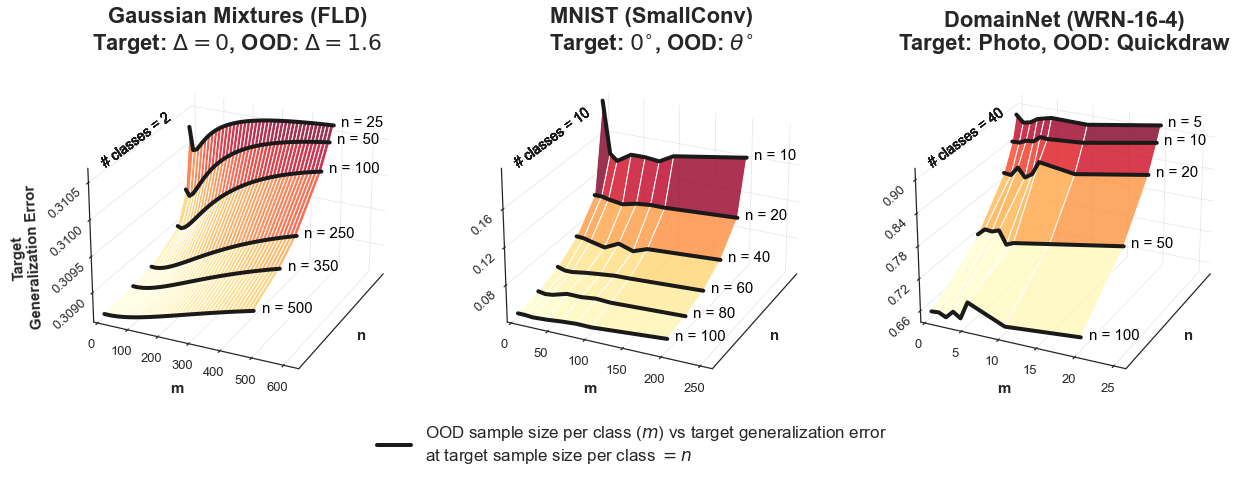

In [94]:
fontsize = 22
labelsize = 15
lw = 4
markersize=4

fig = plt.figure(figsize=(21, 7))
pos = [131, 132, 133]
titles = ["Gaussian Mixtures (FLD)" + "\n" + r"Target: $\Delta=0$, OOD: $\Delta=1.6$", 
          "MNIST (SmallConv)" + "\n" + r"Target: $0^{\circ}}$, OOD: $\theta^{\circ}$", 
          "DomainNet (WRN-16-4)" + "\n" + r"Target: Photo, OOD: Quickdraw"]
c = [2, 10, 40]

for i, result in enumerate(results):
    X, Y, risk = result
    ax = fig.add_subplot(pos[i], projection='3d')
    ax.plot_surface(X, Y, risk.T, alpha=0.8, cmap=plt.get_cmap('YlOrRd'))
    for j in range(risk.shape[0]):
        n = X[0,j]*np.ones(len(Y[:, j]))
        m = Y[:, j]
        r = risk[j]
        ax.plot(n, m, r, 'k', lw=lw)
        ax.text(n[-1], m[-1]+0.05*m[-1], r[-1], "n = {}".format(int(n[-1])), color='black', fontsize=labelsize)
        ax.text(np.max(X), 0, np.max(risk), "# classes = {}".format(c[i]), "x", color='k', fontsize=labelsize-1, fontweight='regular')
    ax.set_xlabel("n", fontsize=labelsize, fontweight='bold',labelpad=-5)
    ax.set_ylabel("m", fontsize=labelsize, fontweight='bold',labelpad=10)
    ax.set_ylim([0, m[-1]+0.3*m[-1]])
    ax.set_xticks([])
    if i == 0:
        ax.tick_params(axis='z', which='major', pad=5, labelsize=5, rotation=42)
        ax.zaxis.set_rotate_label(False)
        ax.set_zlabel("Target" + "\n" + "Generalization Error", fontsize=labelsize, fontweight='bold', labelpad=16, rotation=93)
    ax.view_init(25, 25)
    ax.set_title(titles[i], fontsize=fontsize, fontweight='bold')
    ax.zaxis.set_major_locator(MaxNLocator(5))
    ax.tick_params(axis='z', labelsize=labelsize-2, rotation=42)
    ax.tick_params(labelsize=labelsize-2)
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
plt.subplots_adjust(wspace=0.2)

legend_elements = [
    Line2D([0], [0], color='k', lw=4, 
    label=r"OOD sample size per class ($m$) vs target generalization error" + "\n" + r"at target sample size per class $=n$")]
plt.figlegend(handles=legend_elements, loc=8, bbox_to_anchor=(0.5, 0.0), fontsize=labelsize+2, frameon=False)

plt.show()

In [95]:
fig.savefig("../paper/figs/20-effect-of-target-sample-size.pdf", bbox_inches="tight")